<a href="https://colab.research.google.com/github/Hesan1997/SeqBinder/blob/main/notebooks/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Repository Setup

- Checks if the repository is already cloned.
- Uses an absolute path (`/content/SeqBinder`) to avoid nested "SeqBinder" folders.
- Changes working directory to the repository's root.

In [ ]:
import os

# Use an absolute path to the repository
repo_path = "/content/SeqBinder"

# Clone the repo only if it doesn't exist at the specified absolute path
if not os.path.exists(repo_path):
    !git clone https://github.com/Hesan1997/SeqBinder.git {repo_path}
else:
    print("Repo already cloned.")

# Change the working directory to the repository's root
%cd {repo_path}

# Environment Setup and Data Loading

- **Core Imports:**
  - Import `torch` and `torch.nn` for deep learning.
  - Import and install `optuna` for hyperparameter tuning.

- **Custom Module Imports:**
  - Import the Trainer, Encoders, and Model components from the `src` folder.

- **Data Handling:**
  - Load the dataset from a pickle file located at `/content/SeqBinder/corpus/PDBBind.pkl` using pandas.

- **Tokenizer Initialization:**
  - `p_tokenizer`: Processes protein sequences with a maximum vocabulary size of 5000.
  - `c_tokenizer`: Processes compound SMILES with a maximum token length of 512.


In [ ]:
import torch
import torch.nn as nn

# Import and install optuna if not already installed
try:
    import optuna
except ImportError:
    !pip install optuna
    import optuna

# Import custom modules from the project
from src.trainer import Trainer
from src.encoders import SMILESTokenizer, CharTokenizer
from src.model import Trunk, ConvBranch, LSTMBranch

# Import pandas for data manipulation
import pandas as pd

# Define a generic file path for the dataset
FILE_PATH = f"/content/SeqBinder/corpus/PDBBind.pkl"

# Load the dataset from a pickle file into a DataFrame
df = pd.read_pickle(FILE_PATH)

# Initialize tokenizers with respective configurations:
# - CharTokenizer for protein sequences with a maximum vocabulary size of 5000.
# - SMILESTokenizer for ISO_SMILES with a maximum token length of 512.
p_tokenizer = CharTokenizer(df["SEQ"], 5000)
c_tokenizer = SMILESTokenizer(df["ISO_SMILES"], 512)

# Dataset and DataLoader Setup

- **Custom Dataset:** `ProteinLigandDataset` tokenizes protein sequences and ligand SMILES, returning PyTorch tensors.
- **Key Methods:**
  - `__init__`: Stores sequences, targets, and tokenizers.
  - `__len__`: Returns dataset size.
  - `__getitem__`: Tokenizes inputs and converts them to tensors.
- **Data Splitting:** Uses a `split_map` to filter the DataFrame by the 'SPLIT' column.
- **DataLoaders:** Creates loaders for training, validation, testing, and a combined train-validation set.
- **Tokenizers:** Uses `p_tokenizer` for proteins and `c_tokenizer` for SMILES.

In [2]:
from torch.utils.data import Dataset, DataLoader


class ProteinLigandDataset(Dataset):
    """
    Custom Dataset for processing protein sequences and ligand SMILES strings.
    """
    def __init__(self, protein_sequences, ligand_smiles, targets, protein_tokenizer, ligand_tokenizer):
        """
        Initialize the dataset with:
        - protein_sequences: A pandas Series of protein sequences.
        - ligand_smiles: A pandas Series of SMILES strings.
        - targets: A pandas Series of target values (e.g., binding affinities).
        - protein_tokenizer: Tokenizer for protein sequences.
        - ligand_tokenizer: Tokenizer for SMILES strings.
        """
        self.protein_sequences = protein_sequences
        self.ligand_smiles = ligand_smiles
        self.targets = targets
        self.protein_tokenizer = protein_tokenizer
        self.ligand_tokenizer = ligand_tokenizer

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.targets)

    def __getitem__(self, index):
        """
        Process the sample at the given index:
        - Tokenize the protein sequence and SMILES string.
        - Convert tokenized outputs and target value into torch tensors.
        """
        protein_tokens = self.protein_tokenizer(self.protein_sequences.iloc[index])
        ligand_tokens = self.ligand_tokenizer(self.ligand_smiles.iloc[index])

        # Return tokenized data and target value as tensors
        return (torch.tensor(protein_tokens),
                torch.tensor(ligand_tokens),
                torch.tensor(self.targets.iloc[index], dtype=torch.float))


# Define the split mapping for concise filtering
split_map = {"train": "TRAIN", "valid": "VALID", "test": "TEST"}

# Create datasets and loaders for each split using dictionary comprehensions
datasets = {name: ProteinLigandDataset(
                df.loc[df["SPLIT"] == label].SEQ,
                df.loc[df["SPLIT"] == label].ISO_SMILES,
                df.loc[df["SPLIT"] == label].LOG_AFFINITY,
                p_tokenizer, c_tokenizer)
            for name, label in split_map.items()}

loaders = {name: DataLoader(datasets[name], batch_size=64, shuffle=True)
           for name in datasets}

# Access individual loaders if needed
train_loader = loaders["train"]
valid_loader = loaders["valid"]
test_loader  = loaders["test"]

# Create a combined training and validation dataset and its loader
train_valid_dataset = ProteinLigandDataset(
    df.loc[df["SPLIT"].isin(["TRAIN", "VALID"])].SEQ,
    df.loc[df["SPLIT"].isin(["TRAIN", "VALID"])].ISO_SMILES,
    df.loc[df["SPLIT"].isin(["TRAIN", "VALID"])].LOG_AFFINITY,
    p_tokenizer, c_tokenizer
)
train_valid_loader = DataLoader(train_valid_dataset, batch_size=64, shuffle=True)

# Objective Function for Hyperparameter Tuning

- **Hyperparameters:**
  - *Protein Branch:* Hidden size and layer count suggested via `trial.suggest_int` (small ranges for quick tests).
  - *Ligand Branch:* Fixed parameters for quick experiments.
  - *Training:* Learning rate suggested via `trial.suggest_float` (log scale).

- **Model Initialization:**
  - **Protein Branch (`LSTMBranch`):** Processes sequences with embedding, bidirectional LSTM, and global max pooling.
  - **Compound Branch (`ConvBranch`):** Processes SMILES with embedding, 1D conv layers, and adaptive max pooling.
  - **Fusion (`Trunk`):** Concatenates branch outputs and passes them through dense layers with ReLU and dropout.
  - Uses `p_tokenizer` and `c_tokenizer` to tokenize input, and the model is moved to GPU.

- **Loss & Optimizer:**
  - Uses MSE loss and AdamW optimizer with the suggested learning rate.

- **Training & Validation:**
  - Trains for a fixed number of epochs (default: 5) with gradient clipping.
  - Evaluates on `valid_loader` to compute and return average validation loss.


In [ ]:
def objective(trial):
    # Hyperparameter configuration:
    # For faster execution, small hyperparameter ranges are used.
    # You can adjust these ranges for the protein branch to explore a broader search space,
    # and similarly set ranges for the ligand branch if desired.
    protein_hidden_size = trial.suggest_int('protein_hidden_size', 16, 32, step=4)
    protein_num_layers = trial.suggest_int('protein_num_layers', 1, 4)

    # Fixed hyperparameters for the ligand branch (small space for faster execution)
    ligand_base_channels = 80
    ligand_kernel_size = 5
    ligand_num_layers = 1

    # Suggested training hyperparameter
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # Initialize the model with the new architecture signature using renamed tokenizers:
    # p_tokenizer and c_tokenizer.
    model = Trunk(
        p_branch=LSTMBranch(
            vocabulary_size=len(p_tokenizer.vocabulary),
            hidden_size=protein_hidden_size,
            num_layers=protein_num_layers
        ),
        c_branch=ConvBranch(
            vocabulary_size=len(c_tokenizer.vocabulary),
            base_channels=ligand_base_channels,
            kernel_size=ligand_kernel_size,
            num_layers=ligand_num_layers
        )
    ).to('cuda')

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Training loop for a fixed number of epochs
    num_epochs = 5  # Adjust the number of epochs as needed
    for epoch in range(num_epochs):
        model.train()
        for protein_batch, ligand_batch, targets in train_loader:
            protein_batch = protein_batch.to('cuda')
            ligand_batch = ligand_batch.to('cuda')
            targets = targets.to('cuda')

            optimizer.zero_grad()
            outputs = model(protein_batch, ligand_batch)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for protein_batch, ligand_batch, targets in valid_loader:
            protein_batch = protein_batch.to('cuda')
            ligand_batch = ligand_batch.to('cuda')
            targets = targets.to('cuda')

            outputs = model(protein_batch, ligand_batch)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

    average_val_loss = total_val_loss / len(valid_loader)
    return average_val_loss

# Hyperparameter Optimization with Optuna

- Creates an Optuna study to minimize validation loss.
- Runs a quick optimization (10 trials by default) for faster execution.
- Prints the best hyperparameters.
- Optionally plots the optimization history.
- Increase `n_trials` for a more thorough search.

In [ ]:
# Create an Optuna study to minimize the validation loss
study = optuna.create_study(direction='minimize')

# Run the optimization with a small number of trials for faster execution.
# If you want a more thorough search, you can increase the number of trials.
study.optimize(objective, n_trials=10)

# Display the best hyperparameters found
print("Best trial:")
print(study.best_trial.params)

# (Optional) Plot the optimization history to visualize performance across trials
import optuna.visualization as viz
viz.plot_optimization_history(study).show()

[I 2025-04-07 16:43:56,201] A new study created in memory with name: no-name-935f4cb7-94b7-467c-8e51-33047b7da8aa
[I 2025-04-07 16:45:47,480] Trial 0 finished with value: 2.6917452655340495 and parameters: {'protein_hidden_size': 20, 'protein_num_layers': 4, 'learning_rate': 0.001479860751596286}. Best is trial 0 with value: 2.6917452655340495.
[I 2025-04-07 16:47:41,475] Trial 1 finished with value: 2.589217317731757 and parameters: {'protein_hidden_size': 24, 'protein_num_layers': 4, 'learning_rate': 0.0010374939335368223}. Best is trial 1 with value: 2.589217317731757.
[I 2025-04-07 16:48:55,941] Trial 2 finished with value: 2.387445961174212 and parameters: {'protein_hidden_size': 24, 'protein_num_layers': 1, 'learning_rate': 0.00992669165519784}. Best is trial 2 with value: 2.387445961174212.
[I 2025-04-07 16:50:31,828] Trial 3 finished with value: 2.466563823976015 and parameters: {'protein_hidden_size': 24, 'protein_num_layers': 3, 'learning_rate': 0.0017712433033439375}. Best i

Best trial:
{'protein_hidden_size': 28, 'protein_num_layers': 2, 'learning_rate': 0.0001873424233761934}


# Model Initialization and Training

- **Model Architecture:**  
  - Protein branch: `LSTMBranch` using `p_tokenizer`.
  - Compound branch: `ConvBranch` using `c_tokenizer`.
  - Fusion module: `Trunk` combines outputs from both branches.

- **Optimizer:**  
  - Uses AdamW with a fixed learning rate.

- **Trainer Setup:**  
  - A `Trainer` instance runs training and validation.
  - Saves the trained model to a specified path.

- **Customization:**  
  - Adjust the save path and training parameters as needed.

In [ ]:
# Initialize the model using updated branches and tokenizers
model = Trunk(
    p_branch=LSTMBranch(
        vocabulary_size=len(p_tokenizer.vocabulary),
        hidden_size=24,
        num_layers=2
    ),
    c_branch=ConvBranch(
        vocabulary_size=len(c_tokenizer.vocabulary),
        base_channels=80,
        kernel_size=5,
        num_layers=1
    )
).to('cuda')

# Set up the optimizer with AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Create a Trainer instance with dataset loaders.
trainer = Trainer(
    train_valid_loader,
    test_loader,
    saveAddress=None  # Change to a valid path (e.g., "path/to/save/your_model.pth") if saving is desired.
)

# Run the training and validation process
df_results = trainer.run(
    model,
    nn.MSELoss(),
    parsUpdater=optimizer,
    numEpochs=15
)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]

# Loss Curve Visualization

- Plots training and validation loss over epochs using Matplotlib.
- Visualizes model performance over time.
- Update the DataFrame variable (`df_results`) and adjust labels/formatting as needed.


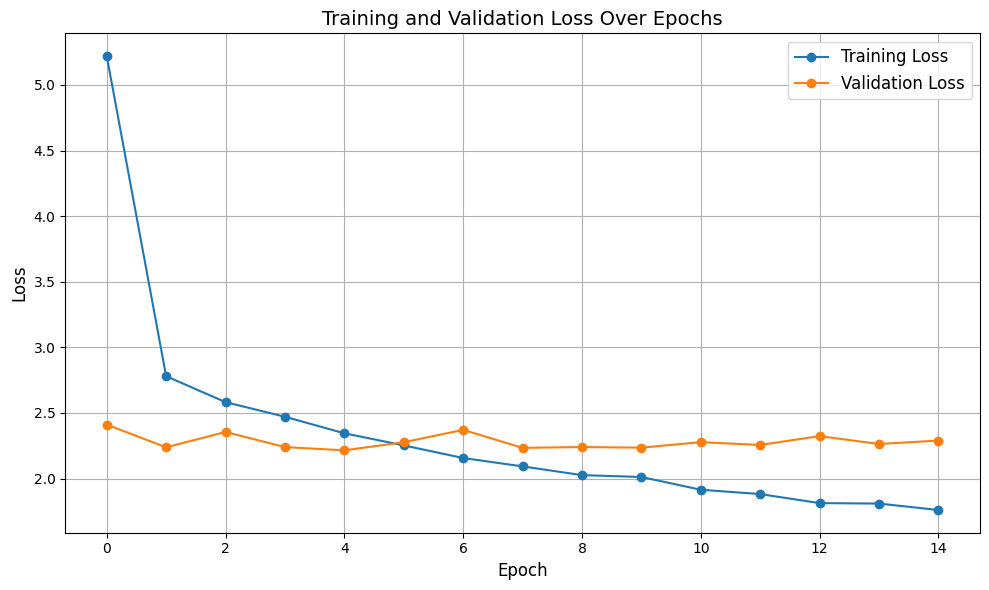

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(df_results["Epoch"], df_results["Training Loss"], label="Training Loss", marker='o')
plt.plot(df_results["Epoch"], df_results["Validation Loss"], label="Validation Loss", marker='o')

# Adding labels, title, and legend
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss Over Epochs", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()